### Generate proper structural connectome data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as pjoin

In [6]:
# import the sc data
sc_dir = "/Users/yilewang/workspaces/data4project/lateralization/connectome/unzip"

# load caseid
table = pd.read_excel("/Users/yilewang/workspaces/data4project/mega_table.xlsx",sheet_name="tvb_parameters")
# get left and right sc weights
def get_sc_values(sc):
    # keep only the upper triangle
    upper = sc.where(np.triu(np.ones(sc.shape)).astype(bool))
    # turn NaN to 0
    upper = upper.fillna(0)
    
    upper_left = upper.iloc[:,::2]
    upper_right = upper.iloc[:,1::2]

    # only take even rows in upper_left
    upper_left = upper_left.iloc[::2,:]
    # only take odd rows in upper_right
    upper_right = upper_right.iloc[1::2,:]

    # flatten upper_left and get non-zero values from upper_left
    upper_left = upper_left.values.flatten()
    upper_left = upper_left[upper_left != 0]
    # flatten upper_right and get non-zero values from upper_right
    upper_right = upper_right.values.flatten()
    upper_right = upper_right[upper_right != 0]
    return upper_left, upper_right

# create an empty dataframe to store the sc values
sc_values = pd.DataFrame(columns=["group", "caseid"])

for group, caseid in zip(table["group"],table["caseid"]):
    sc = pd.read_csv(pjoin(sc_dir,group,caseid,"weights.txt"),sep="\s+",header=None)
    upper_left, upper_right = get_sc_values(sc)

    sc_values = pd.concat([sc_values, pd.DataFrame({"group":[group],"caseid":[caseid],"upper_left":[np.mean(upper_left)],"upper_right":[np.mean(upper_right)]})])
#     for i,j in zip(range(len(upper_left)), range(len(upper_right))):
#        # append the sc values to the dataframe, with group and caseid as first two columns
#        sc_values = pd.concat([sc_values, pd.DataFrame({"group":[group],"caseid":[caseid],"upper_left":upper_left[i],"upper_right":[upper_right[j]]})])
# print(sc_values)


Text(0.5, 0.98, 'SC weights')

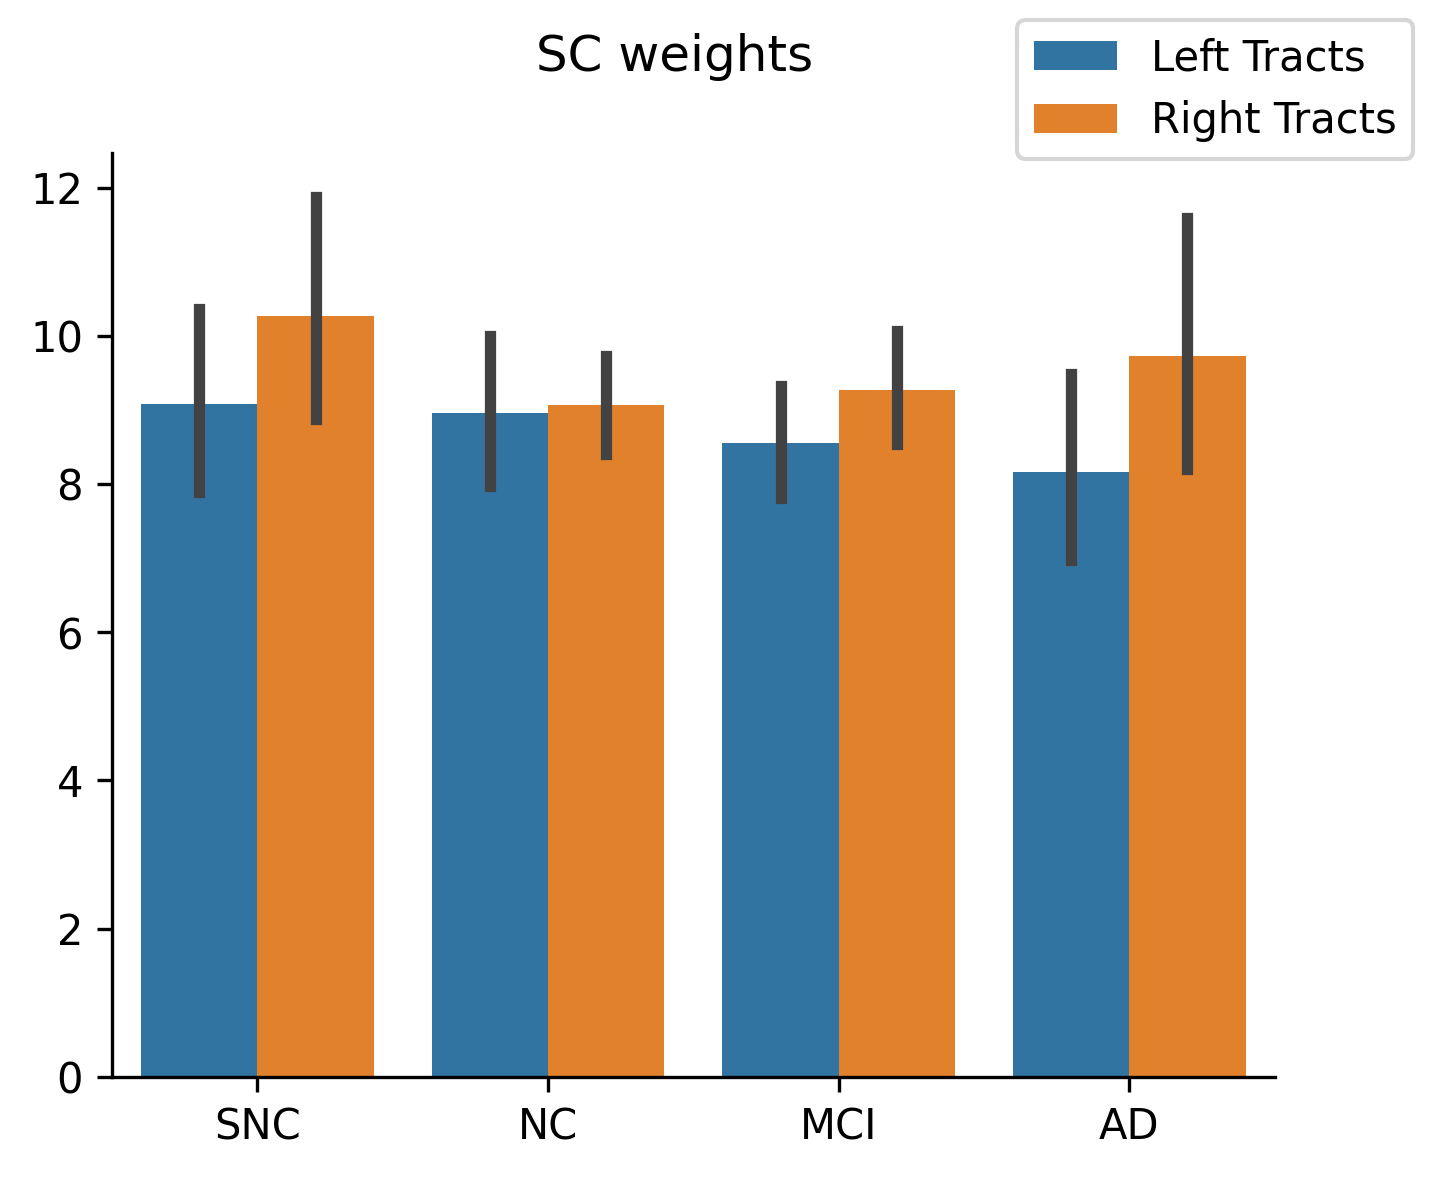

In [26]:
labels = ["Left Tracts"]*74 + ["Right Tracts"]*74
caseids = list(sc_values["caseid"]) + list(sc_values["caseid"])
# concate upper_left and upper_right
values = np.concatenate((sc_values["upper_left"],sc_values["upper_right"]))
groups = np.concatenate((sc_values["group"],sc_values["group"]))

figure = plt.figure(figsize=(5,4), dpi=300)
# sns plot violin plot with dodge

# plot mean using pointplot
sns.barplot(x=groups,y=values,hue=labels,dodge=True)
# sns.pointplot(x=groups, y=values, hue = labels, dodge=.4, markers="o", palette=["red", "red"], errorbar=None, linestyles="none",label=None)
# sns.stripplot(x=groups, y=values, hue=labels, dodge=True, jitter=True,palette='dark:black', label=None, alpha=.25, zorder=1)


plt.legend([],[], frameon=False)
# only keep violinplot legend
handles, _labels = figure.gca().get_legend_handles_labels()
figure.legend(handles[:2], _labels[:2], loc='upper right')
# hide top and right frame
sns.despine(top=True, right=True)
plt.suptitle("SC weights")

In [27]:
df_sc = pd.DataFrame({"group":groups,"caseid":caseids,"values":values,"labels":labels})
df_sc.to_csv("./asymmetry_sc.csv",index=False)

The P-value of the Permutation Test is: 0.29177082291770823


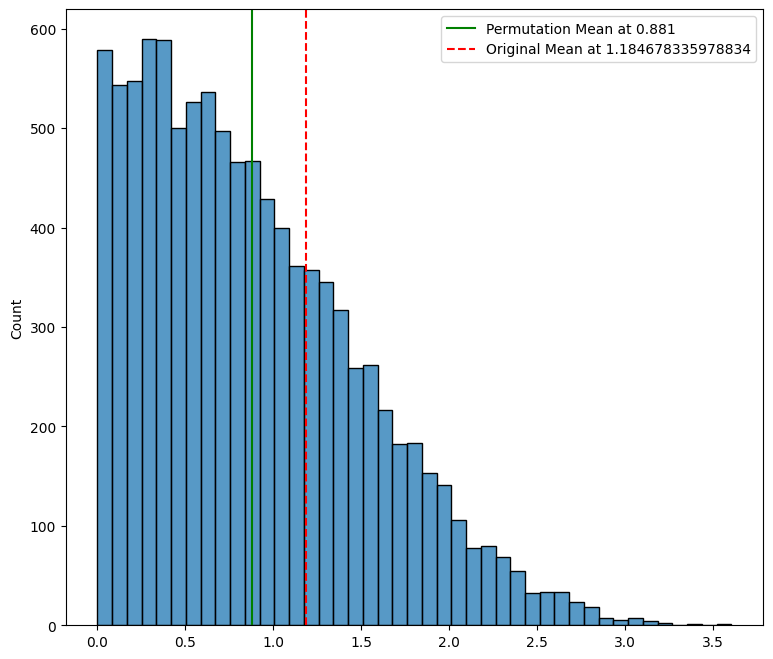

0.29177082291770823
The P-value of the Permutation Test is: 0.8644135586441356


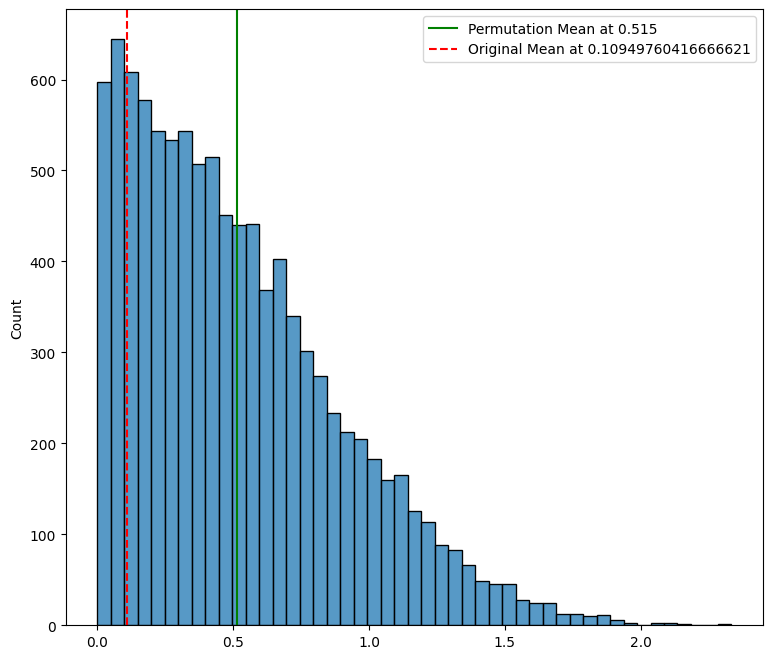

0.8644135586441356
The P-value of the Permutation Test is: 0.21887811218878112


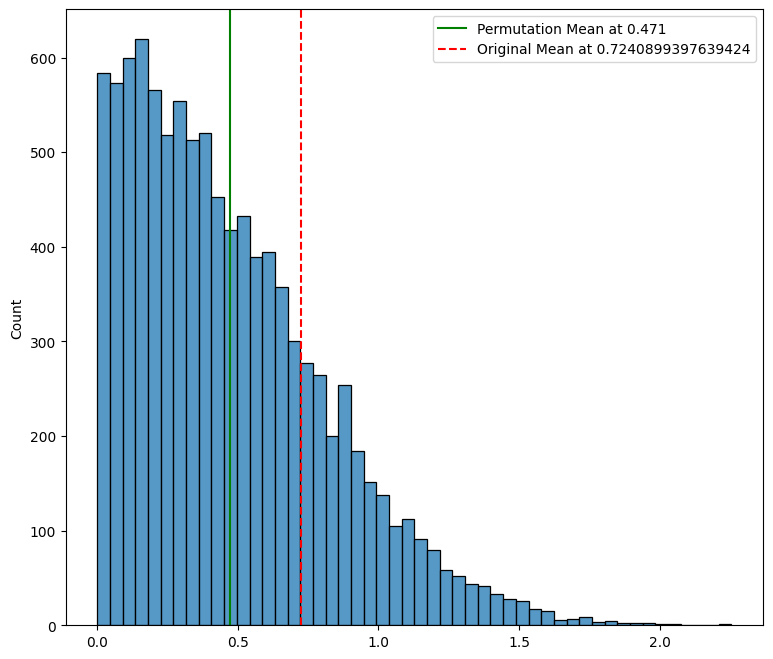

0.21887811218878112
The P-value of the Permutation Test is: 0.18918108189181082


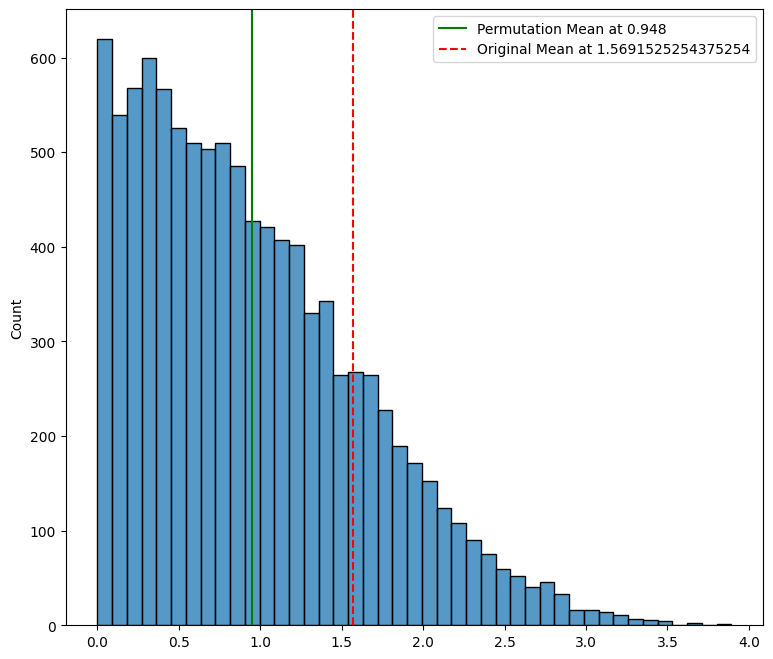

0.18918108189181082


In [ ]:
import sys
sys.path.append("/Users/yilewang/workspaces/")
from tvbtools.tools.statools import stats_calculator, permutation_test

for i in ["SNC","NC", "MCI","AD"]:
    print(permutation_test(sc_values.loc[(sc_values["group"] == i), "upper_left"],sc_values.loc[(sc_values["group"] == i), "upper_right"], iteration=10000, visual=True, tails="two"))

### Weight degree centrality

In [6]:
import networkx as nx
import pandas as pd
case = '/Users/yilewang/workspaces/data4project/lateralization/connectome/unzip/AD/0306A/weights.txt'

# read as numpy array
sc = pd.read_csv(case,sep="\s+",header=None).values

# Create an empty undirected graph
G = nx.Graph()

# Add edges from the matrix
for i in range(len(sc)):
    for j in range(i+1, len(sc)):
        if sc[i][j] != 0:  # Assuming non-zero entries represent edges
            G.add_edge(i, j, weight=sc[i][j])

# Calculate the weighted degree centrality
weighted_degree_centrality = G.degree(weight='weight')

# Print the weighted degree centrality for each node
for node, centrality in zip(G.nodes, weighted_degree_centrality):
    print(f"Node {node}: {centrality}")

ValueError: too many values to unpack (expected 2)